In [2]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from pathlib import Path
from scipy.signal import lfilter, firwin

sys.path.append('../../src/')
from utils import analysis_utils as analysis
from utils import plotting_utils as plotting

## Data settings
from statannot import add_stat_annotation

## Plotting settings
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

sns.set_context("talk")

In [3]:
janelia_figures = r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\Conferences\Janelia\figures"

size_col = 4
size_row = 4

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'

# **Janelia conference figures**

## Trial structure and sequence

### Raster plot

In [ ]:
df_summary = pd.DataFrame()

# start_dir = r"Z:\scratch\vr-foraging\data\672106"  # Starting directory to search
# filename_part = '20231108T'  # Part of the filename you're searching for
# session_path = find_file(start_dir, filename_part)

session_path = r"Z:\scratch\vr-foraging\data\672102\20231117T102559"  # Starting directory to search
session = session_path[-15:-7]
mouse = session_path[-22:-16]
session_path = Path(session_path)

data = analysis.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()

data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.OutputClear.load_from_file()
data['config'].streams.TaskLogic.load_from_file()

reward_sites, active_site, encoder, config = analysis.parse_data(data)

patch_limit = analysis.choose_cut(reward_sites, 10)
reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

In [ ]:
# Load treadmill data
# Maybe look at how the traces change with these two ways
encoder = encoder['Encoder']

treadmill_metadata = config.streams.Rig.data["treadmill"]
converter = treadmill_metadata["wheelDiameter"] * np.pi / treadmill_metadata["pulsesPerRevolution"] * (-1 if treadmill_metadata["invertDirection"] else 1)
encoder = encoder.apply(lambda x : x * converter)

encoder.index = pd.to_datetime(encoder.index, unit="s")
encoder = encoder.resample("33ms").sum().interpolate(method="linear") / 0.033
encoder.index = (encoder.index - pd.to_datetime(0))
encoder.index = encoder.index.total_seconds()

In [ ]:
# win = (0, 1500)
win = (200, 245)

show_speed = True
save_name = "session_w_speed"

In [ ]:
data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.PulseSupplyPort0.load_from_file() # Duration of each pulse
data['harp_behavior'].streams.DigitalInputState.load_from_file()

# Find reward sites
sites = data['software_events'].streams.ActiveSite.data

zero_index = sites.index[0]

# Find ChoiceFeedback events (i.e. successful stops)
choice_feedback = data['software_events'].streams.ChoiceFeedback.data

# Check for licks
## mask for digital inputs

di_state = data['harp_behavior'].streams.DigitalInputState.data['DIPort0']
lick_onset = di_state.loc[di_state == True]

# Find give reward event
give_reward = data['harp_behavior'].streams.OutputSet.data[['SupplyPort0']]
give_reward = give_reward.loc[give_reward.SupplyPort0 == True]

# Find hardware reward events
pulse_duration = data['harp_behavior'].streams.PulseSupplyPort0.data
valve_output_pulse = data['harp_behavior'].streams.OutputSet.data['DOPort0']

label_dict = {
    "InterSite": '#808080',
    "Odor 1": '#d95f02',
    "Odor 2": '#1b9e77',
    "InterPatch": '#b3b3b3'}

fig, axs = plt.subplots(1,1, figsize=(20,4))

_legend = {}
done = True
for idx, site in enumerate(sites.iloc[:-1].iterrows()):
    site_label = site[1]['data']["label"]
    if site_label == "Reward":
        site_label = f"Odor {site[1]['data']['odor']['index']+1}"
        facecolor = label_dict[site_label]
    elif site_label == "InterPatch":
        facecolor = label_dict[site_label]
    else:
        site_label = "InterSite"
        facecolor = label_dict["InterSite"]

    p = Rectangle(
        (sites.index[idx] - zero_index, -2), sites.index[idx+1] - sites.index[idx], 8,
        linewidth = 0, facecolor = facecolor, alpha = .5)
    _legend[site_label] = p
    axs.add_patch(p)

s, lw = 400, 2
# Plotting raster
y_idx = -0.4
_legend["Choice Tone"] = axs.scatter(choice_feedback.index - zero_index+0.2,
           choice_feedback.index * 0 + y_idx,
           marker="s", s=100, lw=lw, c='darkblue',
           label="Choice Tone")
y_idx += 1
_legend["Lick"] = axs.scatter(lick_onset.index - zero_index,
           lick_onset.index * 0 + y_idx,
           marker="|", s=s, lw=lw, c='k',
           label="Lick")
_legend["Reward"] = axs.scatter(give_reward.index - zero_index,
           give_reward.index*0 + y_idx,
           marker=".", s=s, lw=lw, c='deepskyblue',
           label="Reward")
y_idx += 1

#ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
axs.set_yticklabels([])
axs.set_xlabel("Time(s)")
axs.set_ylim(bottom=-1, top = 3)
axs.grid(False)
axs.set_xlim(win)

if show_speed:
    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(encoder.index - zero_index, encoder, c="k", label="Encoder", alpha = 0.8)[0]
    v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
#           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
#           lw = 3, color = 'k', fill=0)
axs.set_xlabel("Time(s)")
axs.grid(False)
axs.set_xlim(win)
# axs.get_xaxis().set_visible(False)
axs.set_ylim(bottom=-1, top = 4)
axs.set_yticks([0,3])
axs.yaxis.tick_right()

if save_name is not None:
    plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

## Mice understand trial structure

### **Learning to stop**

#### Single animal example

In [ ]:
df = pd.DataFrame()
for animal in ['103', '104',  '106', '107']:
    print(animal)
    df_temp = pd.read_csv(r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Data\session_df_{}.csv".format(animal), index_col=0)
    df = pd.concat([df, df_temp], axis=0)
    
# df['stopped_average%' ] = df['stopped_average']*100

In [ ]:
colors_list = ['#7B9FF2', '#212AA5', 'black']

mouse = 672107
fig, ax = plt.subplots(figsize=(size_col*2, size_row))
sns.lineplot(data=df.loc[df.animal_id == mouse], x='site_count', y='stopped_average', hue='session', errorbar = None, palette= colors_list)
sns.despine(trim=True)
plt.xlabel('Site number')
plt.ylabel('P(stop)')
plt.title(f'Mouse {mouse}')
plt.locator_params(axis='x', nbins=6)
plt.ylim(0, 1.1)
plt.tight_layout()
fig.savefig(janelia_figures + f'\several_sessions_Pstop_learning_{mouse}.svg', dpi=300)

#### Average of several animals

In [ ]:
fig, ax = plt.subplots(figsize=(size_col*2, size_row))
sns.lineplot(data=df, x='site_count', y='stopped_average', hue='session', errorbar=None, legend=False, palette= colors_list)

plt.xlabel('Site number')
plt.ylabel('P(Stop)')
plt.title('Multiple mice')
plt.text(s= 'N = 5', x= 0.8, y=0.1, transform=ax.transAxes)
plt.tight_layout()
sns.despine(trim=True)
plt.locator_params(axis='x', nbins=6)
# ax.set_xticksparams()
fig.savefig(janelia_figures + '\several_sessions_Pstop_learning.svg', dpi=300)

In [ ]:
new_df = df.groupby(['animal_id', 'session'])['stopped_average'].mean().reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(size_col, size_row))

sns.boxplot(x='session', y='stopped_average', data=new_df, legend = False, width=0.5, palette=colors_list)
# ax.set_ylim(0, 12)
ax.set_xlabel('Session #')
ax.set_ylim(0, 1.1)
ax.set_ylabel('P(Stop)')
# ax.set_ylabel('')
ax.locator_params(axis='y', nbins=4)
ax.set_xticks([0, 1, 2], ['1','2','3'])
sns.despine(trim=True)
plt.tight_layout()
fig.savefig(janelia_figures + f'\PStop_across_learning_boxplot.svg', dpi=300)

#### Stopping curves progression

In [ ]:
def velocity_traces_learning(trial_summary, config, ax1, window: tuple = (-0.5, 2), max_range: int = 60, mean: bool = False, colors: str = 'black'):
    
    ''' Plots the speed traces for each odor label condition '''
    n_odors = trial_summary.odor_label.unique()
    
    for j, odor_label in enumerate(n_odors):
        if len(n_odors) != 1:
            ax = ax1[j]
            ax1[0].set_ylabel('Velocity (cm/s)')
        else:
            ax = ax1        
            ax.set_ylabel('Velocity (cm/s)')

        ax.set_xlabel('Time after odor onset (s)')
        ax.set_ylim(-10,max_range)
        ax.set_xlim(window)
        try:
            threshold = config['operationControl']['positionControl']['stopResponseConfig']['velocityThreshold']
        except:
            threshold = config['taskLogicControl']['positionControl']['stopResponseConfig']['velocityThreshold']
            
        ax.hlines(threshold, window[0], window[1],linewidth=1, linestyles='dashed', color = colors)
        ax.vlines(0, max_range, -10, linewidth=1, linestyles='solid', color = 'black')
        # ax.fill_betweenx(np.arange(-10,max_range,0.1), 0, window[1], color=colors_odors[j], alpha=.3, linewidth=0)
        
        df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label)]
                    .groupby(['total_sites','times'])[['speed']].mean().reset_index())
        
        if mean:
            sns.lineplot(x='times', y='speed', data=df_results, color = colors, ci=('sd'), legend=False, linewidth=2, ax=ax, alpha=0.8)  

    sns.despine()
    plt.tight_layout()

In [ ]:
colors_list = ['#7B9FF2', '#212AA5', 'black']

trial_df = pd.DataFrame()
base_path = 'Z:/scratch/vr-foraging/data/'
batch = 1
# mouse = '672102'
# file_list = ['20230921T102306','20230922T100446','20230925T101118']
# mouse = '672104'
# file_list = ['20230921T111249','20230922T105342','20230925T111958'] ## ,'20230926T104334', 20230927T125104]
mouse = '672107'
file_list = ['20230921T112513','20230922T105936','20230925T114601']

n_odors = [1]
fig, ax1 = plt.subplots(1,len(n_odors), figsize=(len(n_odors)*size_col, size_row), sharex=True, sharey=True)

for file_name, color in zip(file_list, colors_list):
    
    path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(path)
    print(session, mouse)
    try:
        data = analysis.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    try:
        if batch == 1:
            reward_sites, active_site, encoder_data, config =  analysis.parse_data_old(data, path)
        else:  
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()

            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
            
            reward_sites, active_site, encoder_data, config =  analysis.parse_data(data)

    except:
        print('Error with parsing data')
        continue
    
    patch_limit = analysis.choose_cut(reward_sites, 5)
    reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]
    if color == 'black':
        reward_sites = reward_sites.loc[reward_sites.has_choice == True]
    
    trial_summary = plotting.trial_collection(reward_sites, encoder_data, mouse, session, window = (-1, 2))
    velocity_traces_learning(trial_summary, config, ax1, window = (-1, 2), max_range=50, colors = color, mean=True)
    
plt.show()
fig.savefig(janelia_figures + '\stopping_learning_velocity_traces.svg', dpi=300)

### **Learning to leave after depletion**

#### Velocity traces vs reward available in the patch

In [ ]:
def speed_traces_epochs(reward_sites, inter_site, inter_patch, save=False, mean: bool = False, single: bool = True, patch: int = 4):
    window = [-0.1, 1]  
    colors_reward=['#d73027','#fdae61','#abd9e9','#4575b4']        
    n_col = 3

    trial_summary = pd.DataFrame()
    fig, ax = plt.subplots(1,n_col, figsize=(n_col*4,5), sharey=True)  
    for j, dataframe in enumerate([inter_patch, inter_site, reward_sites]):
        for start_reward, row in dataframe.iterrows():
            trial_average = pd.DataFrame()
            if dataframe['label'].values[0] == 'RewardSite':
                trial = encoder_data.loc[start_reward + -0.9: start_reward + 2, 'filtered_velocity']
            else:
                trial = encoder_data.loc[start_reward + window[0]: start_reward + window[1], 'filtered_velocity']
                
            trial.index -=  start_reward
            
            trial_average['speed'] = trial.values
            trial_average['times'] = np.around(trial.index,3)
            
            for column in dataframe.columns:
                trial_average[column] = np.repeat(row[column], len(trial.values))
                
            trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
            
            if single:
                ax[j].plot(trial.index, trial.values, color=colors_reward[int(row['reward_available'])], linewidth=0.5, alpha=0.5)
      
        trial_summary['mouse'] = mouse
        trial_summary['session'] = session
        
        if mean:
            sns.lineplot(data=trial_summary.loc[trial_summary.label == dataframe.label.unique()[0]], hue='reward_available', x='times', y='speed', ax=ax[j], legend=False, ci=None, palette=colors_reward, linewidth=2)
      
        ax[j].vlines(0, -15, 70, color='black', linestyle='solid', linewidth=0.5)

        ax[j].set_ylim(-15,70)
        if dataframe['label'].values[0] == 'Gap':
            ax[j].set_title('InterSite')
            ax[j].set_xlabel('Time after entering InterSite (s)')
            ax[j].hlines(5, window[0], window[1], color='black', linestyle='dashed', linewidth=0.5)

        elif dataframe['label'].values[0] == 'InterPatch':
            ax[j].set_title('InterPatch')
            ax[j].set_xlabel('Time after entering InterPatch (s)')
            ax[j].hlines(5, window[0], window[1], color='black', linestyle='dashed', linewidth=0.5)

        else:
            ax[j].set_title('Site')
            ax[j].hlines(5, -1, 2, color='black', linestyle='dashed', linewidth=0.5)
            ax[j].set_xlabel('Time after odor onset (s)')


    ax[0].set_ylabel('Velocity (cm/s)')
    plt.suptitle(f'{mouse} {session} - Speed traces')
    sns.despine()
    handles = [mpatches.Patch(color=colors_reward[i], label=f'{i}') for i in range(4)]

    ax[0].legend(handles=handles, ncol=2, title='Reward remaining \n in patch', loc='upper center', bbox_to_anchor=(0.5, 0.5))
    plt.tight_layout()
    
    fig.savefig(janelia_figures + f'\\reward_available_velocity_traces_reward_{patch}.svg', dpi=300)
    

In [ ]:
base_path = 'Z:/scratch/vr-foraging/data/'
batch = 1
patch = 4
mouse = "672103"
file_name = "20231027T101535"

path = os.path.join(base_path, mouse, file_name)
session = file_name[:8]
session_path = Path(path)

print(session, mouse)

try:
    data = analysis.load_session_data(session_path)
except:
    raise ValueError('Error with loading data')

try:
    if batch == 1:
        reward_sites, active_site, encoder_data, config =  analysis.parse_data_old(data, path)

    else:  
        data['harp_olfactometer'].streams.OdorValveState.load_from_file()
        data['harp_olfactometer'].streams.EndValveState.load_from_file()

        data['harp_behavior'].streams.OutputSet.load_from_file()
        data['harp_behavior'].streams.OutputClear.load_from_file()
        data['config'].streams['TaskLogic'].load_from_file()
        
        reward_sites, active_site, encoder_data, config =  analysis.parse_data(data)

except:
    raise ValueError('Error with parsing data')
    
patch_limit = analysis.choose_cut(reward_sites, 10)
reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

if reward_sites.reward_available.max() != 21 and batch == 2:
    raise ValueError('Dont select this session')
elif reward_sites.reward_available.max() != 3 and batch == 1:
    raise ValueError('Dont select this session')

# Group by 'label' and count unique values in 'values' column
unique_counts = reward_sites.groupby('odor_label')['reward_available'].nunique()

# Get the odor label with 3 rewards
if 1 in unique_counts.values:
    rewarded_odor = unique_counts[unique_counts == patch].index[0]
else:
    raise ValueError('More than 3 rewards per site')

reward_sites['reward_available'] /= reward_sites['amount'] 

label = 'InterSite'
inter_site = active_site.loc[active_site['label'] == label]
if inter_site.empty:
    label = 'Gap'
    inter_site = active_site.loc[active_site['label'] == label]

inter_site = pd.concat([inter_site[['start_position','label']], reward_sites[['reward_available','start_position','label', 'odor_label']]])
inter_site = inter_site.sort_index()
inter_site['reward_available_site'] = inter_site['reward_available'].shift(-1)
inter_site['odor_label_site'] = inter_site['odor_label'].shift(-1)
inter_site= inter_site.loc[(inter_site['label'] == label)&(inter_site['odor_label_site'] == rewarded_odor)]
inter_site.drop(columns=['reward_available', 'odor_label'], inplace=True)
inter_site.dropna(inplace=True)

inter_site.rename(columns={'reward_available_site':'reward_available', 'odor_label_site': 'odor_label'}, inplace=True)

inter_patch = active_site.loc[active_site['label'] == 'InterPatch']

inter_patch = pd.concat([inter_patch[['start_position','label']], reward_sites[['reward_available','start_position','label', 'odor_label']]])
inter_patch = inter_patch.sort_index()
inter_patch['reward_available_site'] = inter_patch['reward_available'].shift(-1)
inter_patch['odor_label_site'] = inter_patch['odor_label'].shift(-1)
inter_patch= inter_patch.loc[(inter_patch['label'] == 'InterPatch')&(inter_patch['odor_label_site'] == rewarded_odor)]
inter_patch.drop(columns=['reward_available', 'odor_label'], inplace=True)
inter_patch.dropna(inplace=True)

inter_patch.rename(columns={'reward_available_site':'reward_available', 'odor_label_site': 'odor_label'}, inplace=True)

reward_sites = reward_sites.loc[reward_sites['odor_label'] == rewarded_odor]
speed_traces_epochs(reward_sites, inter_site, inter_patch, patch=patch)



#### P(Leaving) after depletion

In [ ]:
summary_df = pd.read_csv(r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Data" + f'\PLeaving_across_learning.csv', index_col=0)

In [ ]:
colors_list = ['coral', 'crimson', 'darkred']

mouse = 672106
fig, ax = plt.subplots(figsize=(size_col*2, size_row))
sns.lineplot(x='active_new', y='average_past', hue='session', palette=colors_list, data=summary_df.loc[summary_df.mouse == mouse], errorbar='se', ax=ax)
ax.set_xlim(-1,40)
ax.set_ylim(0, 12)
ax.locator_params(axis='x', nbins=6)
ax.locator_params(axis='y', nbins=4)
ax.set_xlabel('Patch number')
ax.set_ylabel('Sequential failures \nbefore leaving')
sns.despine(trim=True)
plt.tight_layout()
plt.legend(title='Depletion session')
# fig.savefig(janelia_figures + f'\{mouse}_PLeaving_across_learning.svg', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(size_col*2, size_row))
sns.lineplot(x='active_new', y='average_past', hue='session', palette=colors_list, data=summary_df, legend=False, errorbar='se', ax=ax)
ax.set_xlim(-1,40)
ax.set_ylim(0, 12)
ax.locator_params(axis='x', nbins=6)
ax.locator_params(axis='y', nbins=3)
ax.set_xlabel('Patch number')
ax.set_ylabel('Sequential failures \n before leaving')
sns.despine(trim=True)
plt.tight_layout()
# fig.savefig(janelia_figures + f'\PLeaving_across_learning.svg', dpi=300)

In [ ]:
new_df = summary_df.groupby(['mouse', 'session'])['average_past'].mean().reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(size_col, size_row))

sns.boxplot(x='session', y='average_past', data=new_df, legend = False, width=0.5, palette=colors_list)
ax.set_ylim(0, 12)
ax.set_xlabel('Session #')
ax.set_ylabel('Sequential failures \nbefore leaving')
ax.locator_params(axis='y', nbins=4)
sns.despine(trim=True)
plt.tight_layout()
# fig.savefig(janelia_figures + f'\PLeaving_across_learning_boxplot.svg', dpi=300)

### Probabilistic/ Deterministic

#### P(Leaving) after depletion or probabilitic failure

In [ ]:
df_results_summary = pd.read_csv(r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Data\type_errors_summary.csv", index_col=0)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))

palette = sns.color_palette("muted")
summary = df_results_summary.loc[df_results_summary.types_errors_next != 0].groupby(['mouse','types_errors_next'])['has_choice'].mean().reset_index()
summary['leaving'] = 1 - summary['has_choice']

sns.lineplot(x='types_errors_next', y='leaving', data=summary, hue='mouse', marker='o', palette = palette, ci=None, legend=False)
plt.xlabel('Previous failure type')
plt.ylabel('P(leave) current site')
plt.xticks([1,2], ['Deterministic', 'Probabilistic'])
plt.ylim(0.4, 0.8)
sns.despine(trim=True)
plt.tight_layout()

fig.savefig(janelia_figures + f'\PLeave_type_errors.svg', dpi=300)

#### Speed traces after error stopped

In [ ]:
def velocity_traces_types_errors(trial_summary: pd.DataFrame, window: tuple = (-2, 4), save=False):

    pdf_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Data\figures'
    n_odors = trial_summary.odor_label.unique()
    # n_odors = ['Alpha-pinene']
    fig, ax1 = plt.subplots(2,len(n_odors), figsize=((len(n_odors))*4, size_row*2), sharex=True, sharey=True)

    colors = ['orange','darkgreen', 'indigo']
    # rewards= [ '#d73027', '#4575b4']
    rewards= [ '#d73027', 'black']
    for j, odor_label in enumerate(n_odors):
        ax1[0][0].set_ylabel('Velocity (cm/s)')
        ax1[0][j].set_xlabel('Time after odor onset (s)')
        ax1[0][j].set_ylim(-15,80)
        ax1[0][j].set_xlim(window)
        ax1[0][j].hlines(5, window[0], window[1], color='black', linewidth=1, linestyles=':')
        ax1[0][j].fill_betweenx(np.arange(-10,80,0.1), 0,0.1, color='#808080', alpha=.5, linewidth=0)
        
        df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label)]
                    .groupby(['total_sites','times', 'types_errors'])[['speed']].mean().reset_index())
        
        if df_results.empty:
            continue
        
        for site in df_results.total_sites.unique():
            plot_df = df_results.loc[df_results.total_sites==site]
            collected = int(plot_df['types_errors'].unique()[0])-1
            sns.lineplot(x='times', y='speed', data=plot_df, color= rewards[collected], legend=False, linewidth=0.5, alpha=0.5, ax=ax1[0][j])  
        
        sns.lineplot(x='times', y='speed', data=df_results, hue='types_errors', palette=rewards, ci=('sd'), linewidth=2, ax=ax1[1][j])  
        ax1[0][j].set_title(f'Odor {odor_label} {trial_summary.loc[(trial_summary.odor_label == odor_label)]["amount"].max()}', color = colors[j])

    ax1[1][j].set_xlabel('Time after sound onset (s)')
    ax1[1][j].set_ylim(-15,80)
    ax1[1][j].set_xlim(window)
    ax1[1][j].hlines(5, window[0], window[1], color='black', linewidth=1, linestyles=':')
    ax1[1][j].fill_betweenx(np.arange(-10,80,0.1), 0,0.1, color='#808080', alpha=.5, linewidth=0)
    ax1[1][j].legend(loc='upper right', title='Error type', fontsize='small')
    sns.despine()     
    plt.suptitle(mouse +'_' + session)       
    plt.tight_layout()

    if save != False:
        save.savefig(fig, bbox_inches='tight')
    else:
        plt.show()
    plt.close(fig)

    # fig.savefig(pdf_path+'\\' + f'{mouse} {session}_speed_poster.pdf', bbox_inches='tight')
    # fig.savefig(pdf_path+'\\' + f'{mouse} {session}_speed_poster.svg', bbox_inches='tight')

In [ ]:
def trial_collection(reward_sites: pd.DataFrame, encoder_data: pd.DataFrame, mouse: str, session: str, aligned: str=None, window: tuple=(-0.5, 2)):
    '''
    Crop the snippets of speed traces that are aligned to different epochs
    
    Parameters
    ----------
    reward_sites : pd.DataFrame
        DataFrame containing the reward sites information
    encoder_data : pd.DataFrame
        DataFrame containing the encoder data
    mouse : str
        Mouse name
    session : str
        Session name
    aligned : str
        Column name to align the snippets
    window : tuple
        Time window to crop the snippets
        
    Returns
    -------
    trial_summary : pd.DataFrame
        DataFrame containing the snippets of speed traces aligned to different epochs
        
        '''
    trial_summary = pd.DataFrame()
        
    for start_reward, row in reward_sites.iterrows():
        trial_average = pd.DataFrame()
        if aligned is not None:
            trial = encoder_data.loc[row[aligned] + window[0]: row[aligned] + window[1], 'filtered_velocity']
            trial.index -=  row[aligned]
        else:
            trial = encoder_data.loc[start_reward + window[0]: start_reward + window[1], 'filtered_velocity']
            trial.index -=  start_reward
        trial_average['speed'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        
        for column in reward_sites.columns:
            trial_average[column] = np.repeat(row[column], len(trial.values))

        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    trial_summary['mouse'] = mouse
    trial_summary['session'] = session
    return trial_summary

In [ ]:
# session_path = r"Z:\scratch\vr-foraging\data\694569\20240129T150611"
session_path = r"Z:\scratch\vr-foraging\data\699894\20240201T104613"

session = session_path[-15:-7]
mouse = session_path[-22:-16]
session_path = Path(session_path)

data = analysis.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()

data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.OutputClear.load_from_file()
data['config'].streams.TaskLogic.load_from_file()

reward_sites, active_site, encoder_data, config = analysis.parse_data(data)

reward_sites['types_errors'] = np.where(((reward_sites['reward_delivered']==0.0)&(reward_sites['has_choice']==True)&(reward_sites['reward_available']==0)), 1, 0)
reward_sites['types_errors'] = np.where(((reward_sites['reward_delivered']==0.0)&(reward_sites['has_choice']==True)&(reward_sites['reward_available']!=0)), 2, reward_sites['types_errors'])
reward_sites['types_errors_next'] = reward_sites['types_errors'].shift(1)

In [ ]:
stop_sites = reward_sites.loc[(reward_sites.stop_time >= 0)&(reward_sites.collected == 0)]
trial_summary = trial_collection(stop_sites, encoder_data, mouse, session, aligned='stop_time', window = (-1, 4))
# velocity_traces_types_errors(trial_summary, window = (-1, 4))

In [ ]:
pdf_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Data\figures'

# Group by 'label' and count unique values in 'values' column
unique_counts = reward_sites.groupby('odor_label')['reward_available'].nunique()

# Get the odor label with 3 rewards
odor_label = unique_counts[unique_counts == 4].index[0]

fig, ax1 = plt.subplots(1,2, figsize=(2*size_col, size_row))
window = (-1, 4)
rewards= [ '#d73027', 'black']

for j in [0,1]:
    ax1[j].set_ylabel('Velocity (cm/s)')
    ax1[j].set_xlabel('Time after choice tone onset (s)')
    ax1[j].set_ylim(-15,70)
    ax1[j].set_xlim(window)
    ax1[j].hlines(8, window[0], window[1], color='black', linewidth=1, linestyles='dashed')
    ax1[j].fill_betweenx(np.arange(-15,70,0.1), 0,0.2, color='#808080', alpha=.5, linewidth=0)

df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label)]
            .groupby(['total_sites','times', 'types_errors'])[['speed']].mean().reset_index())

for site in df_results.total_sites.unique():
    plot_df = df_results.loc[df_results.total_sites==site]
    collected = int(plot_df['types_errors'].unique()[0])-1
    sns.lineplot(x='times', y='speed', data=plot_df, color=rewards[collected], legend=False, linewidth=0.5, alpha=0.5, ax=ax1[0])  

sns.lineplot(x='times', y='speed', data=df_results, hue='types_errors', palette=rewards, ci=('sd'), linewidth=2, ax=ax1[1])  

sns.despine()     
handles = [mpatches.Patch(color=rewards[0], label=f'Deterministic failure'),
           mpatches.Patch(color=rewards[1], label=f'Probability failure')]
plt.legend(loc='upper right', handles=handles, title='Failure type', fontsize='small')
plt.tight_layout()

df_results['mouse'] = mouse
df_results['session'] = session

fig.savefig(janelia_figures+'\\' + f'{mouse} {session}_error_types_sound_onset.svg',  dpi=300)

In [ ]:
df_results_summary = pd.DataFrame()
start_dir = 'Z:/scratch/vr-foraging/data/'
batch = 2
colors_list = sns.palettes.color_palette('husl', 5)

mouse_list = ['690164','690165','690167','699899','699895', '699894', '672569']
file_list = ['20240202T', '20240205T','20240131T','20240116T','20240129T','20240202T','20240125T']

for file_name, color, mouse in zip(file_list, colors_list, mouse_list):
    print(file_name, mouse)
    path = find_file(start_dir + mouse+"/", file_name)
    session_path = Path(path)
    try:
        data = analysis.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    try:
        if batch == 1:
            reward_sites, active_site, encoder_data, config =  analysis.parse_data_old(data, path)
        else:  
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()

            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
            
            reward_sites, active_site, encoder_data, config =  analysis.parse_data(data)

    except:
        print('Error with parsing data')
        continue
    
    patch_limit = analysis.choose_cut(reward_sites, 10)
    reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

    # Group by 'label' and count unique values in 'values' column
    unique_counts = reward_sites.groupby('odor_label')['reward_available'].nunique()

    # Get the odor label with 3 rewards
    rewarded_odor = unique_counts[unique_counts == 4].index[0]

    reward_sites = reward_sites.loc[reward_sites.odor_label == rewarded_odor]
    
    reward_sites['types_errors'] = np.where(((reward_sites['reward_delivered']==0.0)&(reward_sites['has_choice']==True)&(reward_sites['reward_available']==0)), 1, 0)
    reward_sites['types_errors'] = np.where(((reward_sites['reward_delivered']==0.0)&(reward_sites['has_choice']==True)&(reward_sites['reward_available']!=0)), 2, reward_sites['types_errors'])
    reward_sites['mouse'] = mouse
    reward_sites['session'] = file_name
    
    stop_sites = reward_sites.loc[(reward_sites.stop_time >= 0)]
    # stop_sites = reward_sites.loc[(reward_sites.stop_time >= 0)&(reward_sites.collected == 0)]
    trial_summary = trial_collection(stop_sites, encoder_data, mouse, session, aligned='stop_time', window = (-2, 4))

    df_results_summary = pd.concat([df_results_summary, trial_summary])
    


In [ ]:
n_odors = trial_summary.odor_label.unique()
df_results = df_results_summary.groupby(['mouse','times', 'types_errors', 'odor_label'])[['speed']].mean().reset_index()    

fig, ax1 = plt.subplots(1,1, figsize=(size_col, size_row))
window = (-1, 4)
rewards= [ '#d73027', 'black']

ax1.set_ylabel('Velocity (cm/s)')

df_results = (df_results.loc[(df_results.types_errors != 0)]
            .groupby(['times', 'types_errors', 'mouse'])[['speed']].mean().reset_index())

sns.lineplot(x='times', y='speed', data=df_results, hue='types_errors', ci=('sd'), palette=rewards, linewidth=2, ax=ax1)  

ax1.set_xlabel('Time after sound onset (s)')
ax1.set_ylim(-15,70)
ax1.set_xlim(window)
ax1.hlines(8, window[0], window[1], color='black', linewidth=1, linestyles='dashed')
ax1.fill_betweenx(np.arange(-15,70,0.1), 0,0.2, color='#808080', alpha=.5, linewidth=0)
ax1.legend(loc='upper right', title='Error type', fontsize='small', bbox_to_anchor=(2, 1), borderaxespad=0.)
sns.despine()       
plt.tight_layout()

fig.savefig(janelia_figures+'\\' + f'error_velocity_traces_onlyerrors.svg', bbox_inches='tight')

## **Flexibility**

### Reaction to different reward continguencies

In [ ]:
def velocity_traces_odor_summary_poster(trial_summary, config, mouse, session, window: tuple = (-0.5, 2), max_range: int = 60, mean: bool = False, save=False):
    
    ''' Plots the speed traces for each odor label condition '''
    # n_odors = trial_summary.odor_label.unique()

    if trial_summary.loc[trial_summary.odor_label == 'Amyl Acetate'].amount.iloc[0] == 3:
        n_odors = [ 'Alpha-pinene','Amyl Acetate', 'Eugenol']
        colors_odors = ['#1b9e77',  '#d95f02', '#7570b3']
    else:
        n_odors = ['Amyl Acetate', 'Alpha-pinene', 'Eugenol']
        colors_odors = ['#d95f02',  '#1b9e77', '#7570b3']
    
    fig, ax1 = plt.subplots(1,len(n_odors), figsize=(len(n_odors)*3.5, size_row), sharex=True, sharey=True)

    for j, odor_label in enumerate(n_odors):
        if len(n_odors) != 1:
            ax = ax1[j]
            ax1[0].set_ylabel('Velocity (cm/s)')
        else:
            ax = ax1        
            ax.set_ylabel('Velocity (cm/s)')

        ax.set_xlabel('Time after odor onset (s)')
        ax.set_ylim(-13,max_range)
        ax.set_xlim(window)
        ax.hlines(5, window[0], window[1], color='black', linewidth=1, linestyles='dashed')
        ax.fill_betweenx(np.arange(-20,max_range,0.1), 0, window[1], color=colors_odors[j], alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(-20,max_range,0.1), window[0], 0, color='grey', alpha=.3, linewidth=0)

        df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label)&(trial_summary.visit_number == 0)]
                    .groupby(['reward_available','total_sites','times','amount'])[['speed']].median().reset_index())
        
        if df_results.empty:
            continue
        
        for site in df_results.total_sites.unique():
            plot_df = df_results.loc[df_results.total_sites==site]
            sns.lineplot(x='times', y='speed', data=plot_df, color='black', legend=False, linewidth=0.4, alpha=0.4, ax=ax)  
        
        if mean:
            sns.lineplot(x='times', y='speed', data=df_results, color='black', ci=None, legend=False, linewidth=2, ax=ax)  

        # print(df_results.amount.unique())
        # if df_results.amount.unique()[0] == 7:
        #     ax.set_title(f'High reward')
        # elif df_results.amount.unique()[0] == 0:
        #     ax.set_title(f'No reward')
        # else:
        #     ax.set_title(f'Low reward')
    sns.despine()     
    plt.tight_layout()
    fig.savefig(janelia_figures+'\\' + f'{mouse}_{session}_velocity_odor_examples.svg', bbox_inches='tight')


In [ ]:
def find_file(start_dir, filename_part):
    for filename in os.listdir(start_dir):
        if filename_part in filename:
            return os.path.join(start_dir, filename)

In [ ]:
# session_path = r"Z:\scratch\vr-foraging\data\694569\20240129T150611"
# session_path = r"Z:\scratch\vr-foraging\data\699894\20240201T104613"

# Example usage
# start_dir = r"Z:\scratch\vr-foraging\data\690167"  # Starting directory to search
# filename_part = '20240116T'  # Part of the filename you're searching for

start_dir = r"Z:\scratch\vr-foraging\data\690164"  # Starting directory to search
filename_part = '20240130'  # Part of the filename you're searching for

session_path = find_file(start_dir, filename_part)

session = session_path[-15:-7]
mouse = session_path[-22:-16]
session_path = Path(session_path)

data = analysis.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()

data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.OutputClear.load_from_file()
data['config'].streams.TaskLogic.load_from_file()

reward_sites, active_site, encoder_data, config = analysis.parse_data(data)

patch_limit = analysis.choose_cut(reward_sites, 10)
reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

In [ ]:
trial_summary = plotting.trial_collection(reward_sites, encoder_data, mouse, session, window = (-1, 2))
velocity_traces_odor_summary_poster(trial_summary, config, mouse, session, window = (-1, 2), max_range = 80, mean=False, save=False)

### Reversal experiments with batch 2

In [ ]:
base_path = 'Z:/scratch/vr-foraging/data/'
batch = 2
summary_df = pd.DataFrame()
# mouse = ['694569']
# file_list = ['20240208T115713','20240215T114212','20240216T102043']

mouse = ['690164']
file_list = ['20240212T111123','20240214T105021','20240215T113732']

# mouse = ['699894']
# file_list = ['20240213T081458','20240214T081320','20240215T095531']

mouse_list = ['694569','694569', '694569', '690164', '690164', '690164', '699894', '699894', '699894']
file_list = ['20240208T115713','20240215T114212','20240216T102043','20240212T111123','20240214T105021','20240215T113732','20240213T081458','20240214T081320','20240215T095531']

session_n=0
for file_name, mouse in zip(file_list, mouse_list):
    if session_n == 3:
        session_n = 0
    session_n += 1
    path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(path)
    print(session, mouse)
    try:
        data = analysis.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    try:
        if batch == 1:
            reward_sites, active_site, encoder_data, config =  analysis.parse_data_old(data, path)
            print(batch)
        else:  
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()

            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
            
            reward_sites, active_site, encoder_data, config =  analysis.parse_data(data)

    except:
        print('Error with parsing data')
        continue
    
    patch_limit = analysis.choose_cut(reward_sites, 10)
    reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]
    
    reward_sites['maximum_reward'] = np.where(reward_sites['odor_label'] == 'Eugenol', 0, 21)
    reward_sites['harvested'] = (reward_sites['maximum_reward']-reward_sites['reward_available'])/21
    reward_sites['harvested_average'] = analysis.compute_window(reward_sites, 5, 'harvested', 'active_patch')
    
    maximum = reward_sites.active_patch.max()
    reward_sites['reversed_patch'] = maximum - reward_sites['active_patch'].values

    reward_sites['mouse'] = mouse
    reward_sites['session'] = session_n
    summary_df = pd.concat([reward_sites, summary_df], axis=0)

In [ ]:
palette = {0: 'yellow', 7: 'darkorange', 3: 'indigo'}
mouse = '694569'
fig, ax = plt.subplots(1,len(summary_df.session.unique()), figsize=(size_col*len(summary_df.session.unique()), size_row), sharey= True)
for session in summary_df.session.unique():
    new_df = summary_df.loc[(summary_df.session == session)&(summary_df.mouse == mouse)].groupby(['active_patch', 'reversed_patch', 'amount']).agg({'harvested': 'max'}).reset_index()
    for amount in [3, 7]:
        df= new_df.loc[new_df.amount == amount]
        df = df.loc[df.active_patch > 3]
        if session == 1:
            patch = 'reversed_patch'
            ax[session-1].set_xlim(df.active_patch.max(), 0)
        else:
            patch = 'active_patch'
        df['harvested_average'] = analysis.compute_window(df, 5, 'harvested', patch)
        sns.lineplot(data=df, x=patch, y='harvested_average', legend=False, color=palette[amount], marker='.', linewidth=1, ax=ax[session-1])
        ax[session-1].set_xlabel('Patch number')
        ax[session-1].set_ylabel('Fraction of reward \n collected')
        ax[session-1].set_title(f'Session {session}')
        
ax[1].yaxis.set_visible(False)
ax[1].spines['left'].set_color('none')
ax[2].yaxis.set_visible(False)
ax[2].spines['left'].set_color('none')
ax[0].locator_params(axis='y', nbins=4)
handles = [mpatches.Patch(color=palette[odor], label=odor) for odor in palette.keys()]
plt.legend(title='Odor', handles=handles, loc='upper left',
           bbox_to_anchor=(1.05, 1))
sns.despine()

In [ ]:
palette = {'Alpha-pinene': '#1b9e77', 'Amyl Acetate': '#d95f02'}
for mouse in ['694569', '690164', '699894']:
    fig, ax = plt.subplots(1,len(summary_df.session.unique()), figsize=(size_col*len(summary_df.session.unique()), size_row), sharey= True)
    for session in sorted(summary_df.session.unique()):
        new_df = summary_df.loc[(summary_df.session == session)&(summary_df.mouse == mouse)].groupby(['active_patch', 'reversed_patch', 'odor_label']).agg({'harvested': 'max'}).reset_index()
        for odor_label in ['Amyl Acetate', 'Alpha-pinene']:
            df= new_df.loc[new_df.odor_label == odor_label]
            df = df.loc[df.active_patch > 3]
            df = df.loc[df.active_patch < df.active_patch.max() - 10]
            if session == 1:
                patch = 'reversed_patch'
                ax[session-1].set_xlim(df.active_patch.max(), 0)
            else:
                patch = 'active_patch'
                if session == 2:
                    session_top = df.active_patch.max()
                else:
                    df['active_patch'] = session_top + df['active_patch']
                    
            df['harvested_average'] = analysis.compute_window(df, 5, 'harvested', patch)
            sns.lineplot(data=df, x=patch, y='harvested_average', legend=False, color=palette[odor_label], marker='.', linewidth=1, ax=ax[session-1])
            ax[session-1].set_xlabel('Patch number')
            ax[session-1].set_ylabel('Fract. of rewards \n collected')
            ax[session-1].set_title(f'Session {session}')
            
    ax[1].yaxis.set_visible(False)
    ax[1].spines['left'].set_color('none')
    ax[2].yaxis.set_visible(False)
    ax[2].spines['left'].set_color('none')
    ax[0].locator_params(axis='y', nbins=4)
    handles = [mpatches.Patch(color=palette[odor], label=odor) for odor in palette.keys()]
    plt.legend(title='Odor', handles=handles, loc='upper left',
            bbox_to_anchor=(1.05, 1))
    sns.despine()
    plt.tight_layout()
    fig.savefig(janelia_figures + f'\{mouse}_reversal.svg', dpi=300)

## **Generalization**

### Two new odors

In [ ]:
from utils import processing
import json

try:
    ## Load data from encoder efficiently
    data['harp_behavior'].streams.AnalogData.load_from_file()
    encoder_data = data['harp_behavior'].streams.AnalogData.data
except:
    encoder_data = pd.DataFrame()
    encoder_data['Encoder']  = read_harp_bin(path + "\Behavior\Register__44"+".bin")[1]

try:
    # Open and read the JSON file
    with open(str(path)+'\Config\TaskLogic.json', 'r') as json_file:
        config = json.load(json_file)
        
except:
    with open(str(path)+'\config.json', 'r') as json_file:
        config = json.load(json_file)
    
try:
    wheel_size = config.streams.Rig.data['treadmill']['wheelDiameter']
    PPR = -config.streams.Rig.data['treadmill']['pulsesPerRevolution']
    
except:
    wheel_size = 15
    PPR = -8192.0

perimeter = wheel_size*np.pi
resolution = perimeter / PPR
encoder_data['velocity'] = (encoder_data['Encoder'] * resolution)*1000

# Reindex the seconds so they are aligned to beginning of the session
start_time = encoder_data.index[0]
# encoder_data.index -= start_time

# Get the first odor onset per reward site
data['software_events'].streams.ActiveSite.load_from_file()
active_site = data['software_events'].streams.ActiveSite.data

# Use json_normalize to create a new DataFrame from the 'data' column
df_normalized = pd.json_normalize(active_site['data'])
df_normalized.index = active_site.index

# Concatenate the normalized DataFrame with the original DataFrame
active_site = pd.concat([active_site, df_normalized], axis=1)

active_site['label'] = np.where(active_site['label'] == 'Reward', 'RewardSite', active_site['label'])
active_site.rename(columns={'startPosition':'start_position'}, inplace= True)
# Rename columns

active_site = active_site[['label', 'start_position','length']]
reward_sites = active_site[active_site['label'] == 'RewardSite']

data['software_events'].streams.GiveReward.load_from_file()
reward = data['software_events'].streams.GiveReward.data
reward.fillna(0, inplace=True)

try:
    data['software_events'].streams.ActivePatch.load_from_file()
    patches = data['software_events'].streams.ActivePatch.data

except:
    patches = active_site.loc[active_site['label'] == 'InterPatch']
    patches.rename(columns={'label':'name'}, inplace=True)
    patches['name'] = np.where(patches['name'] == 'InterPatch', 'ActivePatch', patches['name'])

try:
    # Old way of obtaining the reward amount
    reward_available = event[1]["data"]["patchRewardFunction"]["initialRewardAmount"]
except:
    reward_available = config['environmentStatistics']['patches'][0]['patchRewardFunction']['initialRewardAmount']
            
reward_updates = pd.concat([patches, reward])
reward_updates.sort_index(inplace=True)
reward_updates["current_reward"] = np.nan

for event in reward_updates.iterrows():
    if event[1]["name"] == 'GiveReward': #update reward
        reward_available -= event[1]["data"]
    elif event[1]["name"] == 'ActivePatch': #reset reward
        try:
            # Old way of obtaining the reward amount
            reward_available = event[1]["data"]["patchRewardFunction"]["initialRewardAmount"]
        except:
            reward_available = config['environmentStatistics']['patches'][0]['patchRewardFunction']['initialRewardAmount']
    else:
        raise ValueError("Unknown event type")
    reward_updates.at[event[0], "current_reward"] = reward_available
    
for site in reward_sites.itertuples():
    try:
        arg_min, val_min = processing.find_closest(site.Index, reward_updates.index.values, mode="below_zero")
        reward_sites.loc[site.Index, "reward_available"] = reward_updates["current_reward"].loc[arg_min]
    except:
        continue

# Find responses to Reward site
data['software_events'].streams.ChoiceFeedback.load_from_file()
choiceFeedback = data['software_events'].streams.ChoiceFeedback.data

reward_sites.loc[:, "active_patch"] = -1
reward_sites.loc[:, "visit_number"] = -1
reward_sites.loc[:, "has_choice"] = False
reward_sites.loc[:, "reward_delivered"] = 0
reward_sites.loc[:, "past_no_reward_count"] = 0
past_no_reward_counter = 0
current_patch_idx = -1

visit_number = 0
for idx, event in enumerate(reward_sites.iterrows()):
    arg_min, val_min = processing.find_closest(event[0], patches.index.values, mode="below_zero")
    if not(np.isnan(arg_min)):
        reward_sites.loc[event[0], "active_patch"] = arg_min
    if current_patch_idx != arg_min:
        current_patch_idx = arg_min
        visit_number = 0
    else:
        visit_number += 1
    reward_sites.loc[event[0], "visit_number"] = visit_number

    if idx < len(reward_sites) - 1:
        choice = choiceFeedback.loc[(choiceFeedback.index >= reward_sites.index[idx]) & (choiceFeedback.index < reward_sites.index[idx+1])]
        reward_in_site = reward.loc[(reward.index >= reward_sites.index[idx]) & (reward.index < reward_sites.index[idx+1])]
    else:
        choice = choiceFeedback.loc[(choiceFeedback.index >= reward_sites.index[idx])]
        reward_in_site = reward.loc[(reward.index >= reward_sites.index[idx])]
    reward_sites.loc[event[0], "has_choice"] = len(choice) > 0
    reward_sites.loc[event[0], "reward_delivered"] = reward_in_site.iloc[0]["data"] if len(reward_in_site) > 0 else 0
    reward_sites.loc[event[0], "past_no_reward_count"] = past_no_reward_counter
    if reward_sites.loc[event[0], "reward_delivered"] == 0 and reward_sites.loc[event[0], "has_choice"] == 1:
        past_no_reward_counter += 1
    else:
        past_no_reward_counter = 0
try:
    df_patch = pd.json_normalize(patches['data'])
    df_patch.reset_index(inplace=True)
    df_patch.rename(columns={'index':'active_patch', 'label': 'odor_label', 'rewardSpecifications.amount': 'amount'}, inplace=True)
    df_patch.rename(columns={'reward_specification.reward_function.amount.value': 'amount'}, inplace=True)
except:
    df_patch = pd.DataFrame(columns=['active_patch', 'odor_label', 'amount'])
    df_patch['active_patch'] = np.arange(len(patches))
    df_patch['odor_label'] = config['environmentStatistics']['patches'][0]['label']
    df_patch['amount'] = config['environmentStatistics']['patches'][0]['rewardSpecifications']['amount']
    
reward_sites = pd.merge(reward_sites.reset_index(),df_patch[['odor_label', 'active_patch', 'amount']],  on='active_patch')

# Create new column for adjusted seconds to start of session
reward_sites['adj_seconds'] = reward_sites['Seconds'] - start_time
reward_sites.index = reward_sites['Seconds']
reward_sites.drop(columns=['Seconds'], inplace=True)

# ---------------- Add water triggers times ---------------- #
data['harp_behavior'].streams.OutputSet.load_from_file()
water = data['harp_behavior'].streams.OutputSet.data[['SupplyPort0']]
reward_sites['next_index'] = reward_sites.index.to_series().shift(-1)
reward_sites['water_onset'] = None

# Iterate through the actual index of df1
for value in water.index:
    # Check if the value is between 'Start' and 'End' in df2
    matching_row = reward_sites[(reward_sites.index <= value) & (reward_sites['next_index'].values >= value)]

    # If a matching row is found, update the corresponding row in water with the index value
    if not matching_row.empty:
        matching_index = matching_row.index[0]  # Assuming there's at most one matching row
        reward_sites.at[matching_index, 'water_onset'] = value
        
# ---------------------------------------------------- #

# ---------------- Add odor triggers times ---------------- #

odor_0 = data['harp_behavior'].streams.OutputSet.data['SupplyPort1']
odor_1 = data['harp_behavior'].streams.OutputSet.data['SupplyPort2']

odor_0 = odor_0.reset_index()
odor_1 = odor_1.reset_index()

odor_0['odor_onset'] = np.where(odor_0['SupplyPort1'] == 1, config['environmentStatistics']['patches'][0]['label'], None)
odor_1['odor_onset'] = np.where(odor_1['SupplyPort2'] == 1, config['environmentStatistics']['patches'][1]['label'], None)

odor_df = pd.concat([odor_0[['Time','odor_onset']], odor_1[['Time','odor_onset']]])
odor_df.sort_index(inplace=True)
odor_df.dropna(inplace=True)

odor_df['time_diff'] = odor_df['Time'].diff()
odor_df = odor_df.drop(index=odor_df.loc[(odor_df['time_diff'] < 1)&(odor_df.index > 0)].index)

try:
    reward_sites['odor_onset'] = odor_df['Time'].values
except:
    pass

# ---------------- Add stop triggers times ---------------- #
reward_sites['stop_time'] = None

# Iterate through the actual index of df1
for value in choiceFeedback.index:
    # Check if the value is between 'Start' and 'End' in df2
    matching_row = reward_sites[(reward_sites.index <= value) & (reward_sites['next_index'].values >= value)]

    # If a matching row is found, update the corresponding row in water with the index value
    if not matching_row.empty:
        matching_index = matching_row.index[0]  # Assuming there's at most one matching row
        reward_sites.at[matching_index, 'stop_time'] = value
        
reward_sites.drop(columns=['next_index'], inplace=True)
# ---------------------------------------------------- #

# Add colum for site number
reward_sites.loc[:,'total_sites'] = np.arange(len(reward_sites))
reward_sites.loc[:,'depleted'] = np.where(reward_sites['reward_available'] == 0, 1, 0)
reward_sites.loc[:,'collected'] = np.where((reward_sites['reward_delivered'] != 0), 1, 0)

reward_sites['next_visit_number'] = reward_sites['visit_number'].shift(-2)
reward_sites['last_visit'] = np.where(reward_sites['next_visit_number']==0, 1, 0)
reward_sites.drop(columns=['next_visit_number'], inplace=True)

reward_sites['last_site'] = reward_sites['visit_number'].shift(-1)
reward_sites['last_site'] = np.where(reward_sites['last_site'] == 0, 1,0)

reward_sites['next_patch'] = reward_sites['active_patch'].shift(1)
reward_sites['next_odor'] = reward_sites['odor_label'].shift(1)
reward_sites['same_patch'] = np.where((reward_sites['next_patch'] != reward_sites['active_patch'])&(reward_sites['odor_label'] == reward_sites['next_odor'] ), 1, 0)
reward_sites.drop(columns=['next_patch', 'next_odor'], inplace=True)

encoder_data = analysis.fir_filter(encoder_data, 5)

if reward_sites.reward_available.max() >= 100:
    reward_sites['reward_available'] = 100
    

In [ ]:
# ---------------- Add water triggers times ---------------- #
data['harp_behavior'].streams.OutputSet.load_from_file()
water = data['harp_behavior'].streams.OutputSet.data[['SupplyPort0']]
reward_sites['next_index'] = reward_sites.index.to_series().shift(-1)
reward_sites['water_onset'] = None

# Iterate through the actual index of df1
for value in water.index:
    # Check if the value is between 'Start' and 'End' in df2
    matching_row = reward_sites[(reward_sites.index <= value) & (reward_sites['next_index'].values >= value)]

    # If a matching row is found, update the corresponding row in water with the index value
    if not matching_row.empty:
        matching_index = matching_row.index[0]  # Assuming there's at most one matching row
        reward_sites.at[matching_index, 'water_onset'] = value

In [ ]:
reward_updates = reward_updates.loc[reward_updates.current_reward >0]

In [ ]:
for event in reward_updates.iterrows():
    if event[1]["name"] == 'GiveReward': #update reward
        reward_available -= event[1]["data"]
    elif event[1]["name"] == 'ActivePatch': #reset reward
        try:
            # Old way of obtaining the reward amount
            reward_available = event[1]["data"]["patchRewardFunction"]["initialRewardAmount"]
        except:
            reward_available = config['environmentStatistics']['patches'][0]['patchRewardFunction']['initialRewardAmount']
    else:
        raise ValueError("Unknown event type")
    reward_updates.at[event[0], "current_reward"] = reward_available

In [ ]:
start_dir = 'Z:/scratch/vr-foraging/data/'
batch = 1

colors_list = sns.palettes.color_palette('husl', 5)

# mouse_list = ['672102','672103','672107']
# file_list = ['20231003T','20231003T','20231003T']
mouse_list = ['672102']
file_list = ['20231006T']

# fig, ax1 = plt.subplots(1, 3, figsize=(12,4))        

for file_name, color, mouse in zip(file_list, colors_list, mouse_list):
    print(file_name, mouse)
    path = find_file(start_dir + mouse+"/", file_name)
    session_path = Path(path)
    try:
        data = analysis.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    try:
        if batch == 1:
            reward_sites, active_site, encoder_data, config =  analysis.parse_data_old(data, path)
        else:  
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()

            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
            
            reward_sites, active_site, encoder_data, config =  analysis.parse_data(data)

    except:
        print('Error with parsing data')
        continue
    
    patch_limit = analysis.choose_cut(reward_sites, 10)
    reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]
    
    reward_sites = reward_sites.loc[reward_sites.past_no_reward_count != 0]
    active_patch = reward_sites.groupby('active_patch')['past_no_reward_count'].max().reset_index()
    active_patch['active_new'] = np.arange(1, len(active_patch)+1)

    active_patch['average_past'] = analysis.compute_window(active_patch, 3,'past_no_reward_count', 'active_new')

    active_patch['mouse'] = mouse
    active_patch['session'] = session_n
    summary_df = pd.concat([summary_df, active_patch], axis=0)

In [ ]:
analysis.parse_data_old(data, path)

## **Behavioral strategies**

### Count P(Leave) x Time/Rewards/Visit/Failure

In [ ]:
# session_path = r"Z:\scratch\vr-foraging\data\694569\20240129T150611"
# session_path = r"Z:\scratch\vr-foraging\data\699894\20240201T104613"

# Example usage
# start_dir = r"Z:\scratch\vr-foraging\data\690167"  # Starting directory to search
# filename_part = '20240116T'  # Part of the filename you're searching for
df_summary = pd.DataFrame()

start_dir = r"Z:\scratch\vr-foraging\data\672103"  # Starting directory to search
filename_part = '20231117'  # Part of the filename you're searching for

session_path = find_file(start_dir, filename_part)

session = session_path[-15:-7]
mouse = session_path[-22:-16]
session_path = Path(session_path)

data = analysis.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()

data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.OutputClear.load_from_file()
data['config'].streams.TaskLogic.load_from_file()

reward_sites, active_site, encoder_data, config = analysis.parse_data(data)

# patch_limit = analysis.choose_cut(reward_sites, 20)
# reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

plotting.pstay_visit_number(reward_sites, config, save=False)

In [ ]:
trial_df = pd.DataFrame()
start_dir = 'Z:/scratch/vr-foraging/data/'
batch = 1
# mouse = '672102'
# file_list = ['20230921T102306','20230922T100446','20230925T101118']
# mouse = '672104'
# file_list = ['20230921T111249','20230922T105342','20230925T111958'] ## ,'20230926T104334', 20230927T125104]
# '20231116T''672102'
colors_list = sns.palettes.color_palette('muted', 5)

mouse_list = ['672107','672102','672103','672104','672106']
file_list = ['20231031T','20231031','20231115','20231110T','20231108T']

fig, ax1 = plt.subplots(1, 2, figsize=(8,4))        

for file_name, color, mouse in zip(file_list, colors_list, mouse_list):
    print(file_name, mouse)
    path = find_file(start_dir + mouse+"/", file_name)
    session_path = Path(path)
    try:
        data = analysis.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    try:
        if batch == 1:
            reward_sites, active_site, encoder_data, config =  analysis.parse_data_old(data, path)
        else:  
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()

            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
            
            reward_sites, active_site, encoder_data, config =  analysis.parse_data(data)

    except:
        print('Error with parsing data')
        continue
    
    patch_limit = analysis.choose_cut(reward_sites, 10)
    reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

    # Group by 'label' and count unique values in 'values' column
    unique_counts = reward_sites.groupby('odor_label')['reward_available'].nunique()

    # Get the odor label with 3 rewards
    rewarded_odor = unique_counts[unique_counts == 1].index[0]

    reward_sites['amount'] = np.where(reward_sites['odor_label'] != rewarded_odor, 0, reward_sites['amount'])

    for i, amount in enumerate(reward_sites.amount.unique()):
        if reward_sites.loc[reward_sites['amount'] == amount].visit_number.nunique()>2:
            ax = ax1[0]
        else:
            ax = ax1[1]
        df_results = reward_sites.loc[reward_sites['amount'] == amount].groupby('visit_number')['label'].count().reset_index()
        df_results.rename(columns={'label':'total_trials'}, inplace=True)
        df_results = df_results.loc[df_results['total_trials'] >= 7]
        df_results['p(Stay)'] = reward_sites.loc[reward_sites['amount'] == amount].groupby('visit_number')['has_choice'].mean()
        df_results['p(Leaving)'] = 1 - df_results['p(Stay)']
        df_results['visit_number'] = df_results['visit_number'] + 1
        sufficient_sites = df_results.visit_number.unique()
        df_results = df_results.loc[df_results['visit_number'] <= 5]
        
        ax.set_title(amount)
        sns.lineplot(x='visit_number', y='p(Leaving)', data=df_results, color = color, ax=ax, marker = '.')
        ax.set_xlabel("Visit number")
        ax.set_ylabel("P(leave)")
        ax.set_ylim([-0.05, 1.05])
        ax.locator_params(axis='y', nbins=3)   
        ax.set_xticks(sufficient_sites)
        handles = [mpatches.Patch(color=color, label=mouse) for mouse, color in zip(mouse_list, colors_list)]
        plt.legend(handles=handles, title='Mouse', loc='upper right')

    ax1[1].set_ylim([-0.05, 1.05])
    sns.despine(trim=True)
    plt.tight_layout()

fig.savefig(janelia_figures + '\countingvisits.svg', dpi=300)

### WS-LS

In [ ]:
# session_path = r"Z:\scratch\vr-foraging\data\694569\20240129T150611"
# session_path = r"Z:\scratch\vr-foraging\data\699894\20240201T104613"

# Example usage
# start_dir = r"Z:\scratch\vr-foraging\data\690167"  # Starting directory to search
# filename_part = '20240116T'  # Part of the filename you're searching for
df_summary = pd.DataFrame()

start_dir = r"Z:\scratch\vr-foraging\data\699894"  # Starting directory to search
filename_part = '20240112T'  # Part of the filename you're searching for

session_path = find_file(start_dir, filename_part)

session = session_path[-15:-7]
mouse = session_path[-22:-16]
session_path = Path(session_path)

data = analysis.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()

data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.OutputClear.load_from_file()
data['config'].streams.TaskLogic.load_from_file()

reward_sites, active_site, encoder_data, config = analysis.parse_data(data)

patch_limit = analysis.choose_cut(reward_sites, 10)
reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

# Group by 'label' and count unique values in 'values' column
unique_counts = reward_sites.groupby('odor_label')['reward_available'].nunique()

In [ ]:
plotting.pstay_past_no_rewards(reward_sites, config, save=False)

In [ ]:
trial_df = pd.DataFrame()
start_dir = 'Z:/scratch/vr-foraging/data/'
batch = 1
# mouse = '672102'
# file_list = ['20230921T102306','20230922T100446','20230925T101118']
# mouse = '672104'
# file_list = ['20230921T111249','20230922T105342','20230925T111958'] ## ,'20230926T104334', 20230927T125104]
# '20231116T''672102'
colors_list = sns.palettes.color_palette('muted', 5)

mouse_list = ['672107','672102','672103','672104','672106']
file_list = ['20231031T','20231116T','20231024T','20231110T','20231108T']

fig, ax = plt.subplots(1, 1, figsize=(3,4))        

for file_name, color, mouse in zip(file_list, colors_list, mouse_list):
    print(file_name, mouse)
    path = find_file(start_dir + mouse+"/", file_name)
    session_path = Path(path)
    try:
        data = analysis.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    try:
        if batch == 1:
            reward_sites, active_site, encoder_data, config =  analysis.parse_data_old(data, path)
        else:  
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()

            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
            
            reward_sites, active_site, encoder_data, config =  analysis.parse_data(data)

    except:
        print('Error with parsing data')
        continue
    
    patch_limit = analysis.choose_cut(reward_sites, 10)
    reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

    # Group by 'label' and count unique values in 'values' column
    unique_counts = reward_sites.groupby('odor_label')['reward_available'].nunique()

    df_results = reward_sites.loc[reward_sites['amount'] == amount].groupby('past_no_reward_count')['label'].count().reset_index()
    df_results.rename(columns={'label':'total_trials'}, inplace=True)
    df_results = df_results.loc[df_results['total_trials'] >= 5]
    df_results['p(Stay)'] = reward_sites.loc[reward_sites['amount'] == amount].groupby('past_no_reward_count')['has_choice'].mean()
    df_results['p(Leaving)'] = 1 - df_results['p(Stay)']
    sufficient_sites = df_results.past_no_reward_count.unique()
    
    ax.set_title(amount)
    sns.lineplot(x='past_no_reward_count', y='p(Leaving)', data=df_results, color = color, ax=ax, marker = '.')
    ax.set_xlabel("Previous number \n of failures")
    ax.set_ylabel("p(Leaving)")
    ax.set_ylim([-0.05, 1.05])
    ax.locator_params(axis='y', nbins=3)   
    ax.set_xticks(sufficient_sites)
    handles = [mpatches.Patch(color=color, label=mouse) for mouse, color in zip(mouse_list, colors_list)]
    plt.legend(handles=handles, title='Mouse', loc='upper right')
        
    sns.despine(trim=True)
    plt.tight_layout()

fig.savefig(janelia_figures + '\previousfailures.svg', dpi=300)

## Example curves for new experiments

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(size_col,size_col))
# Generate x values
x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
b = 0.254189
b = 0.3812

# Define parameters for the exponential function
a = 7  # Amplitude
y = a * np.exp(-b * x)
print(y)
plt.plot(x+1, y, color='orange', marker= 'o')
plt.text(1.2, a, f'a = {a}', color='orange')

a = 3  # Amplitude
y = a * np.exp(-b * x)
print(y)
plt.plot(x+1, y, color='darkgreen', marker= 'o')
plt.text(1, 0.15, f'a = {a}', color='darkgreen')
plt.title('Changing intercept')
plt.xlabel('Reward collected')
plt.ylabel('P(Reward)')
plt.hlines(3, 0, 11, color='k', linestyle='--')
plt.text(5, 4, f'rate: {np.round(b,2)}', color='k')
plt.locator_params(axis='y', nbins=3)
# plt.ylim(0,1)
sns.despine()
plt.tight_layout()
fig.savefig(janelia_figures + '\intercept_experiment.svg', dpi=300)

In [1]:
fig, ax = plt.subplots(1, 1, figsize=(size_col,size_col))
# Generate x values
x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
b = 0.254189

# Define parameters for the exponential function
a = 0.9  # Amplitude
y = a * np.exp(-b * x)
print(y)
plt.plot(x+1, y, color=color1)
plt.text(1.2, a, f'a = {a}', color=color1)

a = 0.6  # Amplitude
y = a * np.exp(-b * x)
print(y)
plt.plot(x+1, y, color=color2)
plt.text(1, 0.05, f'a = {a}', color=color2)
plt.title('Changing intercept')
plt.xlabel('Rewards collected')
plt.ylabel('P(reward)')
plt.locator_params(axis='y', nbins=3)
plt.ylim(0,1)
plt.xlim(0.5,10)

sns.despine()
plt.tight_layout()
fig.savefig(janelia_figures + '\intercept_experiment.svg', dpi=300)

NameError: name 'plt' is not defined

[7.         4.92927958 3.71613577 3.00540829 2.58902439 2.34508343
 2.20216917 2.118442   2.06938995 2.04065251 2.02381651 2.01395305
 2.00817447 2.00478906 2.0028057  2.00164374 2.00096299 2.00056418
 2.00033053 2.00019364]
[3.         2.58585592 2.34322715 2.20108166 2.11780488 2.06901669
 2.04043383 2.0236884  2.01387799 2.0081305  2.0047633  2.00279061
 2.00163489 2.00095781 2.00056114 2.00032875 2.0001926  2.00011284
 2.00006611 2.00003873]


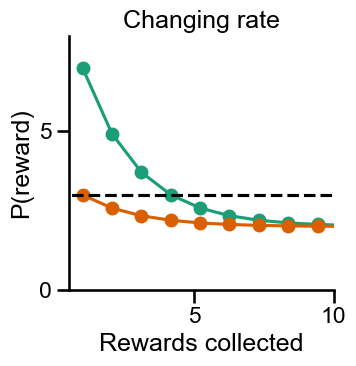

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(size_col,size_col))
x = np.linspace(0, 20, 20)  # Generate 100 points between 0 and 5
a = 5
b = 2.718  # Amplitude
c = 0.508
d = 2
# Generate x values
y = a * pow(b, -c * x) + d
print(y)
plt.plot(x+1, y, color=color2, marker='o')

a = 1
b = 2.718  # Amplitude
d = 2
# Generate x values
y = a * pow(b, -c * x) + d
print(y)
plt.plot(x+1, y, color=color1, marker='o')

plt.title('Changing rate')
plt.xlabel('Rewards collected')
plt.ylabel('P(reward)')
plt.locator_params(axis='y', nbins=3)
plt.hlines(3, 0, 21, color='k', linestyle='--')
plt.ylim(0,8)
plt.xlim(0.5,10)

sns.despine()
plt.tight_layout()